In [61]:
import pandas as pd
import glob
import random
import os
import cv2
from sklearn.utils import shuffle
from numpy.random import seed
import numpy as np
from tensorflow.random import set_seed
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = 100
seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(42)
warnings.filterwarnings('ignore')

In [62]:
img_size = 256
batch_size = 64
seed = 42

In [63]:
main_path = "../chest_xray/"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
validation_path = os.path.join(main_path,"val")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(validation_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(validation_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")


#create list of paths
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

In [67]:
dic_data = {"train":[train_normal, train_pneumonia], "test":[test_normal, test_pneumonia] , "val":[val_normal, val_pneumonia]}
for key, value in dic_data.items():
    classes = [0]*len(value[0])    # Normal : 0 and Pneunomia : 1
    classes.extend([1]*len(value[1]))
    images_path = [x for x in value[0]]
    images_path.extend([x for x in value[1]])
    data = []
    i = 0
    for img_path in images_path:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue
        # resize image shape
        img = cv2.resize(img, (img_size, img_size))
        #normalize image
        img = img/255.0

        data.append([img, classes[i]])
        i = i+1
    df = pd.DataFrame(data, columns=['image', 'label'])
    print(f"{key} shape : {df.shape}")
    df.to_pickle(f"{key}.pkl")

train shape : (5216, 2)
test shape : (624, 2)
val shape : (16, 2)


In [68]:
#read saved formated images
df_train  = pd.read_pickle(os.path.join(main_path,"train.pkl"))
df_test = pd.read_pickle(os.path.join(main_path,"test.pkl"))
df_val = pd.read_pickle(os.path.join(main_path,"val.pkl"))

### Reshape the loaded images

In [69]:
X_train, y_train = np.array([ img.reshape(img_size,img_size, 1) for img in df_train['image']]), np.array(df_train['label'])
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = np.array([ img.reshape(img_size,img_size, 1) for img in df_val['image']]), np.array(df_val['label'])
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = np.array([ img.reshape(img_size,img_size, 1) for img in df_test['image']]), np.array(df_test['label'])
X_test, y_test = shuffle(X_test, y_test, random_state=42)

#### Histogram

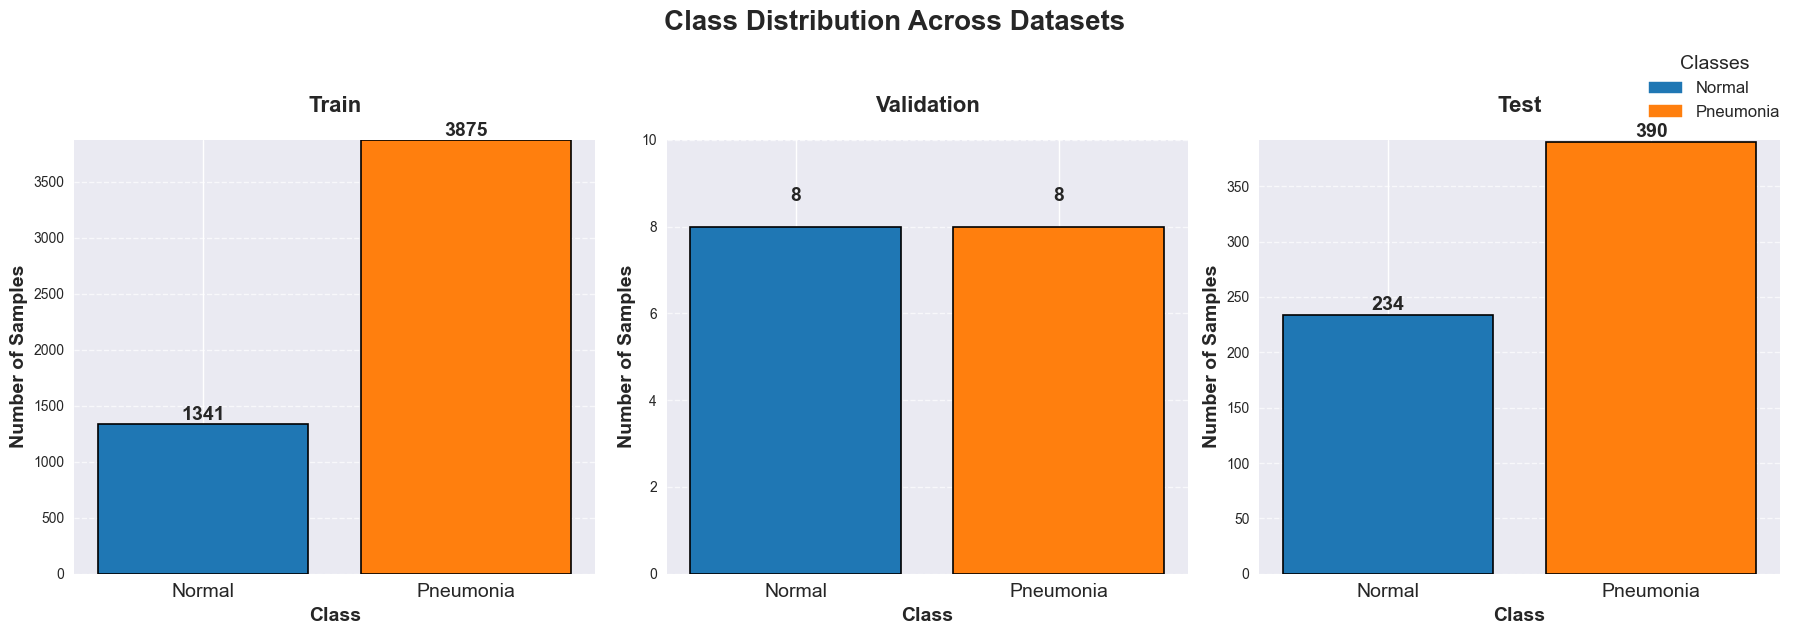

In [70]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define class names (replace with your actual class names)
class_names = ['Normal', 'Pneumonia']

# Set style
sns.set_style("whitegrid")  # Clean grid background
plt.style.use('seaborn')  # Modern and professional style

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
labels = ['Train', 'Validation', 'Test']
list_df = [df_train, df_val, df_test]

# Define a colorblind-friendly color scheme
colors = ['#1f77b4', '#ff7f0e']  # Blue and orange

# Plot bar plots for each dataset
for i, ax in enumerate(axes):
    # Count the number of samples in each class
    class_counts = list_df[i]['label'].value_counts().sort_index()
    
    # Create a bar plot
    bars = ax.bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', linewidth=1.2)
    
    # Add labels and title
    ax.set_title(f'{labels[i]}', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Class', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Samples', fontsize=14, fontweight='bold')
    
    # Set x-ticks and labels
    ax.set_xticks(class_counts.index)
    ax.set_xticklabels(class_names, fontsize=14)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(int(height)),
                ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Add gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis limit for better spacing
    ax.set_ylim(0, max(class_counts.values) + 2)

# Add a main title for the entire figure
fig.suptitle('Class Distribution Across Datasets', fontsize=20, fontweight='bold', y=1.05)

# Add a legend
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], edgecolor='black') for i in range(len(class_names))]
fig.legend(handles, class_names, title='Classes', loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=12, title_fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the plot as a high-resolution image
plt.savefig('class_distribution_professional.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Build CNN model from keras

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import visualkeras

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with precision and recall metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[Precision(name='precision'), Recall(name='recall')])


# Visualize the model using visualkeras
visualkeras.layered_view(
    model,
    legend=True,  # Add a legend
    scale_xy=15,  # Scale the diagram
    scale_z=1,    # Control the height of 3D-like layers
    spacing=50,   # Add spacing between layers
    to_file='model_diagram.png'  # Save as a high-quality image
).show()

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_recall',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

# Train the model
history = model.fit(X_train, 
                    y_train,
                    batch_size=batch_size,
                    epochs=12,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights_dict)
                    #callbacks=[checkpoint])

Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}
Epoch 1/12
82/82 [==============================] - 11s 125ms/step - loss: 0.3167 - precision: 0.9516 - recall: 0.8632 - val_loss: 0.3033 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 2/12
82/82 [==============================] - 10s 122ms/step - loss: 0.1187 - precision: 0.9861 - recall: 0.9554 - val_loss: 0.2702 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 3/12
82/82 [==============================] - 10s 122ms/step - loss: 0.0897 - precision: 0.9894 - recall: 0.9665 - val_loss: 0.2126 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 4/12
82/82 [==============================] - 10s 122ms/step - loss: 0.0698 - precision: 0.9913 - recall: 0.9737 - val_loss: 0.0911 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/12
82/82 [==============================] - 10s 121ms/step - loss: 0.0586 - precision: 0.9934 - recall: 0.9773 - val_loss: 0.4637 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 6/12
82/82 [=====

In [72]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict probabilities
y_pred = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_classes = (y_pred > 0.999).astype(int)

# If y_test is one-hot encoded, convert it to 1D array
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
print(classification_report(y_test, y_pred_classes, target_names=['Normal', 'Pneumonia']))

20/20 [==============================] - 1s 31ms/step
Confusion Matrix:
 [[140  94]
 [ 21 369]]
              precision    recall  f1-score   support

      Normal       0.87      0.60      0.71       234
   Pneumonia       0.80      0.95      0.87       390

    accuracy                           0.82       624
   macro avg       0.83      0.77      0.79       624
weighted avg       0.82      0.82      0.81       624



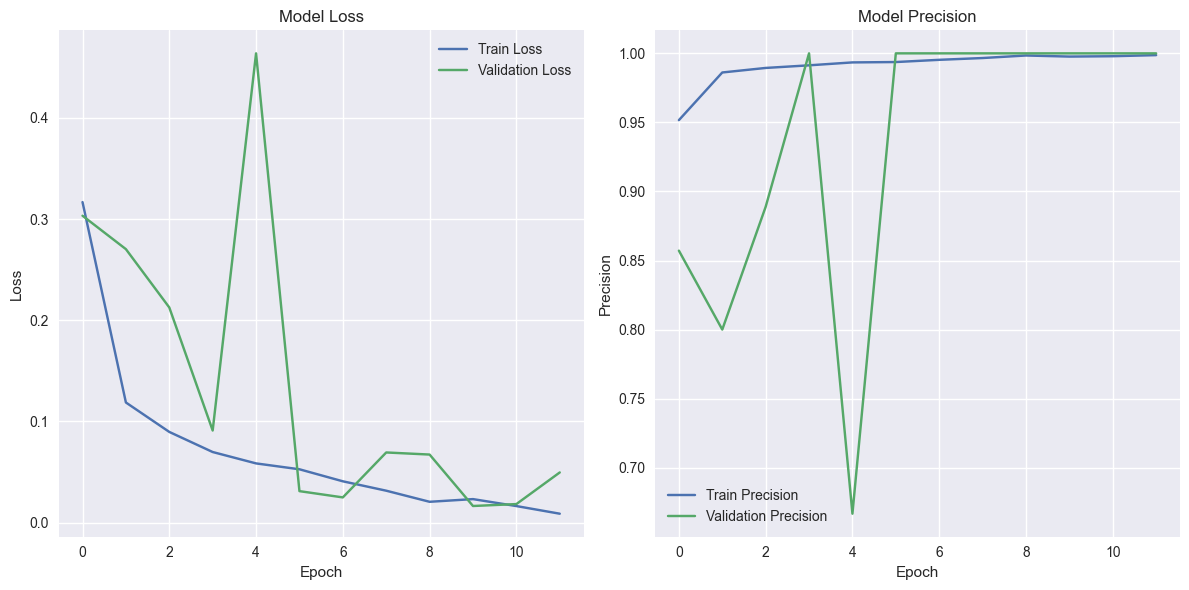

In [73]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy (if available)
plt.subplot(1, 2, 2)
plt.plot(history.history['precision'], label='Train Precision')  # Replace with your metric
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

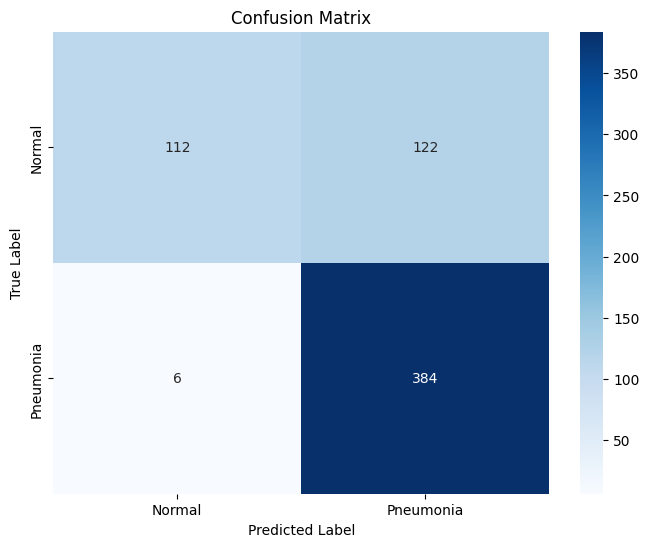

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'], 
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()